<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/time_series_growth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 時系列植物生長解析（仮）
挿絵プレースホルダー
## ライセンス
- DeepPhenoDataデータセット
    - https://figshare.com/articles/dataset/Deep_Phenotyping_Dataset/5492392
    - CC-BY-4.0
- 本稿プログラムコード
    - Dr. Koji Noshita 原案
    - CC-BY-NC-4.0

## 解説
- DeepPhenoDataのデータセットは、シロイヌナズナを上面より撮影した画像を時系列で収録したデータセットです。
- このデータセットの一部を用い、葉面積を定量化し、時系列での変化を可視化します。

## 備考
- 本稿は時系列データを扱うウォーミングアップを目的としています。葉面積定量には、正確性や頑健性が、NDVIや機械学習などを利用した方法と比べて劣るものの、コードの理解容易さを優先にし、HSV閾値による抽出を行います。

## 環境構築

In [3]:
!mkdir data
!wget -q -O ./data/2017NaminetalDeepPheno.zip  https://figshare.com/ndownloader/files/9500311
!unzip -q ./data/2017NaminetalDeepPheno.zip -d ./data

In [1]:
import glob
import os
import re
import datetime
import numpy as np
import pandas as pd

from skimage.measure import label, regionprops

from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import seaborn as sns

import cv2

## 画像の読み込み
DeepPhenoDataは、植物１個体の時系列写真ごとに１つのサブフォルダにまとまったデータセット構造をしています。そのうち、Col-0１個体分のデータを読み込んでみましょう。

In [3]:
DATASET_DIR = "./data/2017-Namin-et-al-DeepPheno/DeepPhenoData"
COL_DIR = os.path.join(DATASET_DIR, 'BVZ0073-GC36L-RGB01~fullres-cor-T03-D4-35057-Col-0')
files = sorted(os.listdir(COL_DIR))
print(len(files))
print(files[:2])

22
['BVZ0073-GC36L-RGB01~fullres-cor-T03-D4-35057_2016_10_01_12_00_00_00.jpg', 'BVZ0073-GC36L-RGB01~fullres-cor-T03-D4-35057_2016_10_02_08_00_00_00.jpg']


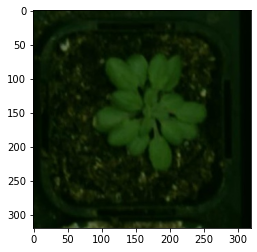

In [8]:
# 撮影時間軸に沿って画像がリスト化されているため、-1のインデックスで最新の画像を取得する
file = files[-1]
image = cv2.imread(os.path.join(COL_DIR,file))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

### 葉面積を求める
前項のイネ種子の面積抽出ではグレースケール変換後、明るさの閾値を設定して面積を抽出しました。しかしながら、他の色空間（例えばHSV）に変換し、葉と背景の差が大きいチャンネルを選択し、閾値を設定することで、より正確な面積抽出が可能なこともあります。

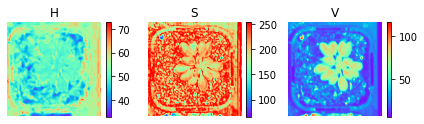

In [14]:
# HSVに変換
hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# それぞれの成分を可視化してみる
for i, c in enumerate(['H', 'S', 'V']):
    plt.subplot(1,3,i+1)
    plt.imshow(hsv_image[:,:,i], cmap='jet')
    plt.title(c)
    plt.colorbar(fraction=0.046)
    plt.axis('off')
plt.tight_layout()

V(Velocity)チャンネルが最も葉と背景の差が大きいことがわかります。このチャンネルを利用して、葉面積を抽出してみましょう。

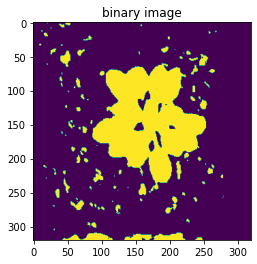

In [15]:
v = hsv_image[:,:,2]
binary = v > 40
plt.title("binary image")
plt.imshow(binary)

葉領域を単離できたものの、背景ノイズが混じっているため、除去する必要があります。検出領域のうち、最も大きい領域を葉領域として抽出することができれば、ノイズ除去が可能です。

そのため、二値化した画像をラベル画像（すなわち、連結成分ごとに異なるラベルを割り振った画像）に変換します。

検出領域の数：107


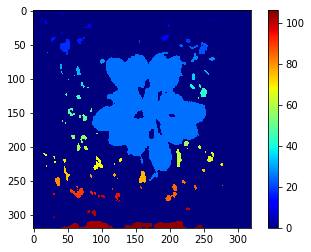

In [19]:
label_image = label(binary)
plt.imshow(label_image, cmap='jet', interpolation="None")
plt.colorbar(fraction=0.046)
print(f"検出領域の数：{len(np.unique(label_image))}")

画像をラベル化することで107個の領域が検出されていることがわかりました。それらのうち、最も面積の大きいものが植物の領域であると仮定します。
各ラベルの面積は、scikit-imageのregionpropsを使うことで計算できます。

Area is: 16679


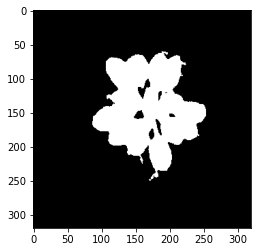

In [21]:
props = regionprops(label_image)
areas = [p.area for p in props]
# 最も大きい面積を持つindexを取得する
idx = np.argmax(areas)
area = areas[idx]
print(f"Area is: {area}")

# 背景のidxを含まないため、idx+1を指定する
plt.imshow(label_image==idx+1, cmap='gray')
plt.show()

以上の手順で葉面積が抽出できました。葉面積の時系列変化を可視化してみましょう。

### ファイル名から撮影時間を抽出する
時系列データの解析では、撮影時間を抽出することが重要です。DeepPhenoDataのデータセットでは、ファイル名に撮影時間が記載されています。ファイル名から撮影時間を抽出するコードを書きます。

In [48]:
# 拡張子の除外
_file = os.path.splitext(files[0])[0]
print(_file)
# 日付のみを抽出。なお、日付のフォーマットはYYYY_MM_DD_HH_MM_SS
date = re.search(r'\d{4}_\d{2}_\d{2}_\d{2}_\d{2}_\d{2}', _file).group()
print(date)
# pythonが扱うことのできるdate formatに変換
date = datetime.datetime.strptime(date, '%Y_%m_%d_%H_%M_%S')
print(date)


BVZ0073-GC36L-RGB01~fullres-cor-T03-D4-35057_2016_10_01_12_00_00_00
2016_10_01_12_00_00
2016-10-01 12:00:00


### 時系列データを作成する

これまでのコードをまとめて、時系列データを作成するコードを書きます。

Area(px):[1114, 1355, 1759, 1572, 1784, 2222, 3085, 3398, 4117, 4777, 5555, 6306, 7772, 11886, 8755, 10283, 11836, 12903, 13631, 14531, 16121, 16679]


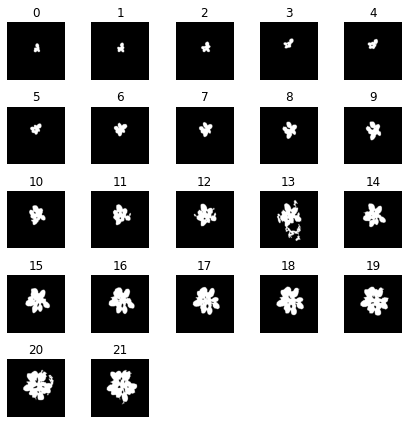

In [26]:
def get_label_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v = hsv_image[:,:,2]
    binary = v > 40
    label_image = label(binary)
    
    return label_image

def get_largest_area_and_idx(binary):
    props = regionprops(label_image)
    areas = [p.area for p in props]
    idx = np.argmax(areas)
    area = areas[idx]
    return area, idx

def get_date_from_filename(file):
    _file = os.path.splitext(file)[0]
    date = re.search(r'\d{4}_\d{2}_\d{2}_\d{2}_\d{2}_\d{2}', _file).group()
    date = datetime.datetime.strptime(date, '%Y_%m_%d_%H_%M_%S')
    return date


x = []  # list to store label(file name)
y = []  # list to store area
    
plt.figure(figsize=(6,6))
for i, file in enumerate(files):
    label_image = get_label_image(os.path.join(COL_DIR,file))
    area, idx = get_largest_area_and_idx(label_image)
    date = get_date_from_filename(file)
    
    x.append(date)
    y.append(area)
    
    plt.subplot(5,5,i+1)
    plt.title(str(i))
    plt.imshow(label_image==idx+1, cmap='gray')
    plt.axis('off')
plt.tight_layout()

print(f"Area(px):{y}")

### 時系列データをプロットする

一部画像についてはご検出の程度が大きいものの、全体的には葉面積が増加していることがわかりました。
次は可視化を行います。

In [27]:
# データフレームに変換
df = pd.DataFrame({'Date': x, 'LeafArea': y})
# convert to hours from the first image
df['Time'] = (df['Date'] - df['Date'].min()).dt.total_seconds() / 3600

df.head()

,Date,LeafArea,Time
0,2016-10-01 12:00:00,1114,0.0
1,2016-10-02 08:00:00,1355,20.0
2,2016-10-03 12:00:00,1759,48.0
3,2016-10-04 12:00:00,1572,72.0
4,2016-10-05 12:00:00,1784,96.0


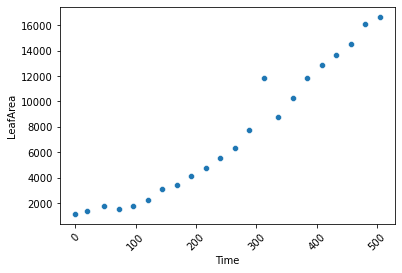

In [28]:
sns.scatterplot(data=df, x="Time", y="LeafArea")
plt.xticks(rotation=45)
plt.show()

### 生育をモデル化する

ロジスティック生育モデルを使って、シロイヌナズナの葉面積増加をモデル化してみましょう。

In [29]:
# Logistic growth function
def logistic_growth(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

xdata = df['Time']
ydata = df['LeafArea']

params, covariance = curve_fit(logistic_growth, xdata, ydata, p0=[max(ydata), 0.01, xdata.median()])
K, r, t0 = params
print(f"K:{K}, r:{r}, t0:{t0}")


K:20582.745584094548, r:0.008749422110445236, t0:346.1769991631295


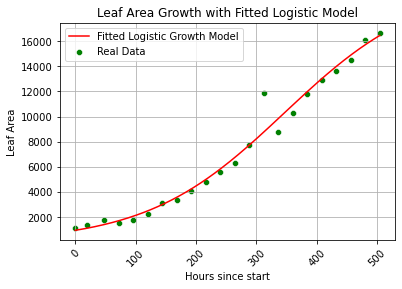

In [30]:
# Generate a range of times for the model prediction
time_range = np.linspace(xdata.min(), xdata.max(), 300)
predicted_growth = logistic_growth(time_range, K, r, t0)


sns.scatterplot(data=df, x="Time", y="LeafArea", color="green", label="Real Data")
sns.lineplot(x=time_range, y=predicted_growth, color='red', label='Fitted Logistic Growth Model')
plt.title('Leaf Area Growth with Fitted Logistic Model')
plt.xlabel('Hours since start')
plt.ylabel('Leaf Area')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## 最後に
解析フォルダを変更して、他の個体のデータについても解析してみましょう。
エコタイプ（Col-0、Ler-1、Sf-2、cviなど）によって生育度合いが異なることがわかります。
また、そのときに、撮影個体やエコタイプによって、葉面積が正常に測れない画像がでてくるかと思います。
今回は、簡易的な面積抽出を行いましたが、機械学習を用いた方法を使うなど、正確な面積抽出を行うことが可能となります。
そのような方法は、次回以降のハンズオンで紹介します。